In [4]:
!!pip install lightgbm

['Requirement already satisfied: lightgbm in /opt/anaconda3/lib/python3.12/site-packages (4.6.0)',
 'Requirement already satisfied: numpy>=1.17.0 in /opt/anaconda3/lib/python3.12/site-packages (from lightgbm) (1.26.4)',
 'Requirement already satisfied: scipy in /opt/anaconda3/lib/python3.12/site-packages (from lightgbm) (1.13.1)']

In [5]:
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score
import numpy as np

# Load the dataset for one fold
def load_one_fole(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    _, group_train = np.unique(qid_train, return_counts=True)
    _, group_test = np.unique(qid_test, return_counts=True)
    return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test

def ndcg_single_query(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

# calculate NDCG score given a trained model 
def compute_ndcg_all(model, X_test, y_test, qids_test, k=10):
    unique_qids = np.unique(qids_test)
    ndcg_ = list()
    for i, qid in enumerate(unique_qids):
        y = y_test[qids_test == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_test[qids_test == qid])

        idcg = ndcg_single_query(y, y, k=k)
        ndcg_.append(ndcg_single_query(p, y, k=k) / idcg)
    return np.mean(ndcg_)

# get importance of features
def get_feature_importance(model, importance_type='gain'):
    return model.booster_.feature_importance(importance_type=importance_type)

# Question 13

Number of unique queries: 6000
Relevance Label Distribution:
Label 0: 377957 occurrences
Label 1: 232569 occurrences
Label 2: 95082 occurrences
Label 3: 12658 occurrences
Label 4: 5146 occurrences


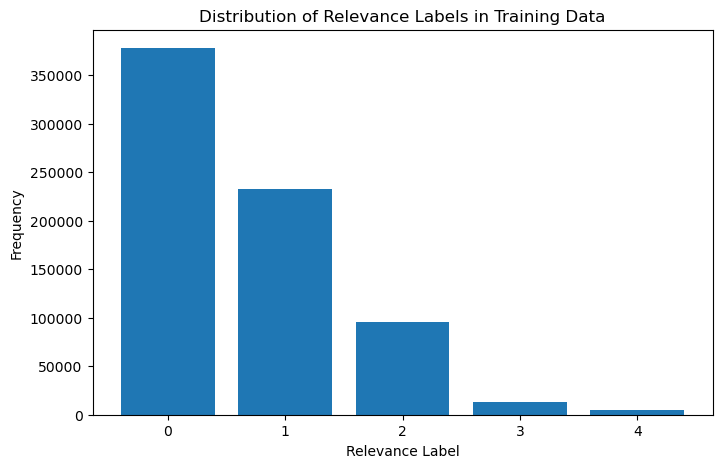

In [6]:
import os
import zipfile
from sklearn.datasets import load_svmlight_file
import numpy as np
import matplotlib.pyplot as plt

file_path = "MSLR-WEB10K.zip"
destination_path = "MSLR-WEB10K"

# checks if the folder already exists, if not extract
if not os.path.exists(destination_path):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(destination_path)
        
data_path = "./MSLR-WEB10K/Fold1/"

# loading dataset
X_train, y_train, qid_train = load_svmlight_file(str(data_path + "train.txt"), query_id=True)

# converting relevance labels to integers
y_train = y_train.astype(int)

num_unique_queries = len(np.unique(qid_train))
print(f"Number of unique queries: {num_unique_queries}")

# computing the distribution of relevance labels
relevance_counts = np.bincount(y_train, minlength=5) 
print("Relevance Label Distribution:")
for label, count in enumerate(relevance_counts):
    print(f"Label {label}: {count} occurrences")

# ploting distribution of relevence labels
plt.figure(figsize=(8, 5))
plt.bar(range(5), relevance_counts, tick_label=[0, 1, 2, 3, 4])
plt.xlabel("Relevance Label")
plt.ylabel("Frequency")
plt.title("Distribution of Relevance Labels in Training Data")
plt.show()


# Question 14

In [7]:
import lightgbm as lgb
import pandas as pd
from IPython.display import display

# definitions
dataset_path = "./MSLR-WEB10K/"
folds = [f"Fold{i}" for i in range(1, 6)]
ndcg_k_values = [3, 5, 10]

# Dictionary to store results
results = {}

# Loop through each fold
for fold in folds:    
    # load training and testing data
    data_path = os.path.join(dataset_path, fold)
    X_train, y_train, qid_train = load_svmlight_file(os.path.join(data_path, "train.txt"), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(os.path.join(data_path, "test.txt"), query_id=True)

    # LightGBM dataset format
    train_data = lgb.Dataset(X_train, label=y_train, group=np.bincount(qid_train.astype(int)))
    test_data = lgb.Dataset(X_test, label=y_test, group=np.bincount(qid_test.astype(int)), reference=train_data)

    # LightGBM parameters
    params = {
        "objective": "lambdarank",
        "metric": "ndcg",
        "ndcg_eval_at": ndcg_k_values,  
        "learning_rate": 0.05, 
        "boosting_type": "gbdt",
        "lambda_l1": 0.1, 
        "lambda_l2": 0.1,  
        "verbosity": -1 
    }


    # training LightGBM model
    model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])  


    # test set score predictions
    y_pred = model.predict(X_test)

    ndcg_scores = {f"nDCG@{k}": ndcg_score([y_test], [y_pred], k=k) for k in ndcg_k_values}

    results[fold] = ndcg_scores

    # Print nDCG results
    print(f"\n{fold} Performance:")
    for metric, score in ndcg_scores.items():
        print(f"{metric}: {score:.4f}")


results_df = pd.DataFrame(results).T
# Simply print the DataFrame
print("\nFinal nDCG Scores:")
display(results_df)



Fold1 Performance:
nDCG@3: 1.0000
nDCG@5: 1.0000
nDCG@10: 0.9266

Fold2 Performance:
nDCG@3: 1.0000
nDCG@5: 1.0000
nDCG@10: 0.9841

Fold3 Performance:
nDCG@3: 0.8827
nDCG@5: 0.9152
nDCG@10: 0.8936

Fold4 Performance:
nDCG@3: 0.9260
nDCG@5: 0.9465
nDCG@10: 0.9487

Fold5 Performance:
nDCG@3: 0.8520
nDCG@5: 0.8930
nDCG@10: 0.9306

Final nDCG Scores:


,nDCG@3,nDCG@5,nDCG@10
Fold1,1.000000,1.000000,0.926636
Fold2,1.000000,1.000000,0.984095
Fold3,0.882680,0.915210,0.893567
Fold4,0.925980,0.946503,0.948721
Fold5,0.851959,0.893007,0.930569


QUESTION 15: Result Analysis and Interpretation:
For each of the five provided folds, list top 5 most important features of the model based on
the importance score. Please use model.booster .feature importance(importance type=’gain’) as
demonstrated here for retrieving importance score per feature. You can also find helper code in the
provided notebook.

In [10]:
def get_feature_importance(model, importance_type='gain'):
    importance_scores = model.feature_importance(importance_type=importance_type)
    feature_names = model.feature_name()
    importance_dict = {name: score for name, score in zip(feature_names, importance_scores)}
    return sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:5]

In [12]:
# Define training parameters
training_params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}

# Set base directory for data
base_dir = './MSLR-WEB10K/Fold'

# Store feature importances across folds
all_feature_importances = []

# Iterate through each fold (1 to 5)
for fold in range(1, 6):
    fold_data_dir = base_dir + str(fold) + "/"  # Generate fold-specific directory path
    
    # Load training and test data for this fold
    train_features, train_labels, train_qids, train_groups, test_features, test_labels, test_qids, test_groups = load_one_fole(fold_data_dir)

    # Create dataset objects for training and evaluation
    training_set = lgb.Dataset(train_features, label=train_labels, group=train_groups)
    validation_set = lgb.Dataset(test_features, label=test_labels, group=test_groups, reference=training_set)

    # Train the LightGBM model
    model = lgb.train(training_params, training_set, num_boost_round=100, valid_sets=[validation_set])

    # Extract and display top 5 feature importances
    important_features = get_feature_importance(model, importance_type='gain')
    print(f"Top 5 Features in Fold {fold} (by gain):")
    for feature_name, feature_value in important_features:
        print(f"{feature_name}: {feature_value}")


Top 5 Features in Fold 1 (by gain):
Column_133: 23856.702950954437
Column_7: 4248.546391487122
Column_107: 4135.244449853897
Column_54: 4078.4632263183594
Column_129: 3635.03702378273
Top 5 Features in Fold 2 (by gain):
Column_133: 23578.90825009346
Column_7: 5157.964912414551
Column_54: 4386.669756650925
Column_107: 4094.0121722221375
Column_129: 4035.0706725120544
Top 5 Features in Fold 3 (by gain):
Column_133: 23218.075441122055
Column_54: 4991.3033719062805
Column_107: 4226.807395458221
Column_129: 4059.7525141239166
Column_7: 3691.792320251465
Top 5 Features in Fold 4 (by gain):
Column_133: 23796.899673223495
Column_7: 4622.622978448868
Column_54: 3883.4817056655884
Column_129: 3356.8469800949097
Column_128: 3207.5755367279053
Top 5 Features in Fold 5 (by gain):
Column_133: 23540.94235444069
Column_7: 4794.9451723098755
Column_54: 4079.608554124832
Column_107: 3514.8357515335083
Column_129: 3209.0584440231323


QUESTION 16: Experiments with Subset of Features:
For each of the five provided folds:

* Remove the top 20 most important features according to the computed importance score in
the question 15. Then train a new LightGBM model on the resulted 116 dimensional query-
url data. Evaluate the performance of this new model on the test set using nDCG. Does
the outcome align with your expectations? If not, please share your hypothesis regarding the
potential reasons for this discrepancy.

* Remove the 60 least important features according to the computed importance score in the
question 15. Then train a new LightGBM model on the resulted 76 dimensional query-url data.
Evaluate the performance of this new model on the test set using nDCG. Does the outcome
align with your expectations? If not, please share your hypothesis regarding the potential
reasons for this discrepancy.

In [13]:
# Load the dataset for one fold
def load_one_fole(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    _, group_train = np.unique(qid_train, return_counts=True)
    _, group_test = np.unique(qid_test, return_counts=True)
    return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test

def ndcg_single_query(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

# calculate NDCG score given a trained model 
def compute_ndcg_all(model, X_test, y_test, qids_test, k=10):
    unique_qids = np.unique(qids_test)
    ndcg_ = list()
    for i, qid in enumerate(unique_qids):
        y = y_test[qids_test == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_test[qids_test == qid])

        idcg = ndcg_single_query(y, y, k=k)
        ndcg_.append(ndcg_single_query(p, y, k=k) / idcg)
    return np.mean(ndcg_)

def get_important_features_indices(model, num_features, least_important=False):
    # Extract feature importances based on gain
    feature_importances = model.feature_importance(importance_type='gain')
    
    # Determine whether to return least or most important features
    sorted_indices = np.argsort(feature_importances)
    return sorted_indices[:num_features] if least_important else sorted_indices[-num_features:]


In [15]:
# Define LightGBM parameters
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}

# Base path for dataset folds
base_data_path = './MSLR-WEB10K/Fold'

# Iterate through each fold
for fold_idx in range(1, 6):
    data_path = base_data_path + str(fold_idx) + "/"  # Generate the fold-specific path
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = load_one_fole(data_path)

    # Prepare LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train, group=group_train)
    test_data = lgb.Dataset(X_test, label=y_test, group=group_test, reference=train_data)

    # Train the initial model
    model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

    # Identify and remove the top 20 most important features
    top_features_indices = get_important_features_indices(model, 20)
    X_train_reduced_top, X_test_reduced_top = X_train[:, top_features_indices], X_test[:, top_features_indices]
    train_data_reduced_top = lgb.Dataset(X_train_reduced_top, label=y_train, group=group_train)
    test_data_reduced_top = lgb.Dataset(X_test_reduced_top, label=y_test, group=group_test)

    # Retrain with top features removed
    model_reduced_top = lgb.train(params, train_data_reduced_top, num_boost_round=100, valid_sets=[test_data_reduced_top])
    ndcg_score_reduced_top = compute_ndcg_all(model_reduced_top, X_test_reduced_top, y_test, qid_test)
    print("Fold {}, Top 20 Features Removed, NDCG Score: {}".format(fold_idx, ndcg_score_reduced_top))

    # Identify and remove the bottom 60 least important features
    bottom_features_indices = get_important_features_indices(model, 60, least_important=True)
    X_train_reduced_bottom, X_test_reduced_bottom = X_train[:, bottom_features_indices], X_test[:, bottom_features_indices]
    train_data_reduced_bottom = lgb.Dataset(X_train_reduced_bottom, label=y_train, group=group_train)
    test_data_reduced_bottom = lgb.Dataset(X_test_reduced_bottom, label=y_test, group=group_test)

    # Retrain with bottom features removed
    model_reduced_bottom = lgb.train(params, train_data_reduced_bottom, num_boost_round=100, valid_sets=[test_data_reduced_bottom])
    ndcg_score_reduced_bottom = compute_ndcg_all(model_reduced_bottom, X_test_reduced_bottom, y_test, qid_test)
    print("Fold {}, Bottom 60 Features Removed, NDCG Score: {}".format(fold_idx, ndcg_score_reduced_bottom))


Fold 1, Top 20 Features Removed, NDCG Score: 0.47827689648179766
Fold 1, Bottom 60 Features Removed, NDCG Score: 0.3725346737876415
Fold 2, Top 20 Features Removed, NDCG Score: 0.4738541279047724
Fold 2, Bottom 60 Features Removed, NDCG Score: 0.35378669585571704
Fold 3, Top 20 Features Removed, NDCG Score: 0.47214671154446586
Fold 3, Bottom 60 Features Removed, NDCG Score: 0.367133083900162
Fold 4, Top 20 Features Removed, NDCG Score: 0.4800954917400635
Fold 4, Bottom 60 Features Removed, NDCG Score: 0.37409776466008327
Fold 5, Top 20 Features Removed, NDCG Score: 0.4839351910646641
Fold 5, Bottom 60 Features Removed, NDCG Score: 0.35427364869638417
